<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_dkl_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKL-GPR for active learning
This notebook demonstrates how to use a deep kernel learning (DKL)-based Gaussian process regression (GPR) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (August 2021)*

Intallations:

In [2]:
!pip install -q torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1
!pip install -q --upgrade git+https://github.com/ziatdinovmax/atomai.git

     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 94.5 MB/s 
     |████████████████████████████████| 7.1 MB 61.8 MB/s 
     |████████████████████████████████| 193 kB 7.4 MB/s 
     |████████████████████████████████| 503 kB 56.0 MB/s 
     |████████████████████████████████| 865 kB 58.1 MB/s 


Imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import atomai as aoi

Download training data:

In [4]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [5]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [6]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [7]:
window_size = 12

coordinates = aoi.utils.get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = aoi.utils.extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

((3264, 12, 12), (3264, 93))

Normalize data:

In [8]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.7151328805097958


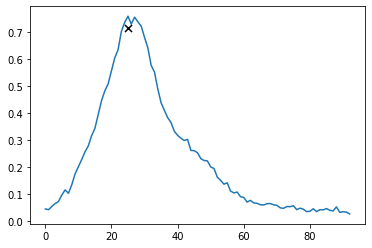

In [9]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [10]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

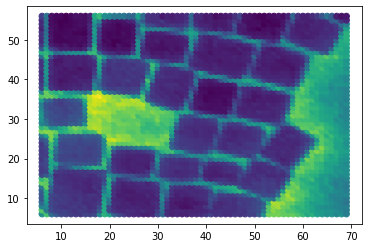

In [11]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [12]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((3264, 144), (3264,))

Train:

In [13]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=100)

Epoch 1/100 ... Training loss: 0.7581
Epoch 10/100 ... Training loss: 0.7123
Epoch 20/100 ... Training loss: 0.6735
Epoch 30/100 ... Training loss: 0.6348
Epoch 40/100 ... Training loss: 0.5954
Epoch 50/100 ... Training loss: 0.5549
Epoch 60/100 ... Training loss: 0.5134
Epoch 70/100 ... Training loss: 0.471
Epoch 80/100 ... Training loss: 0.4272
Epoch 90/100 ... Training loss: 0.3844
Epoch 100/100 ... Training loss: 0.3384


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [14]:
mean, var = dklgp.predict(X, batch_size=len(X))

Text(0.5, 1.0, 'DKL uncertainty')

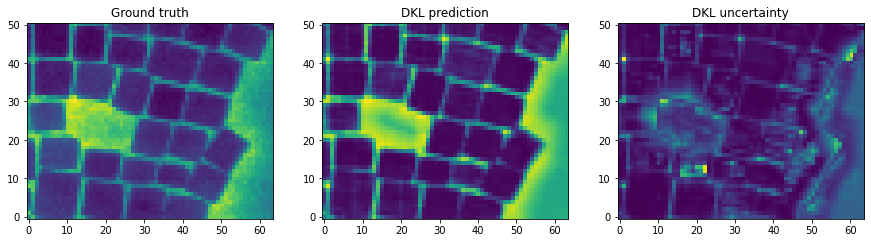

In [15]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

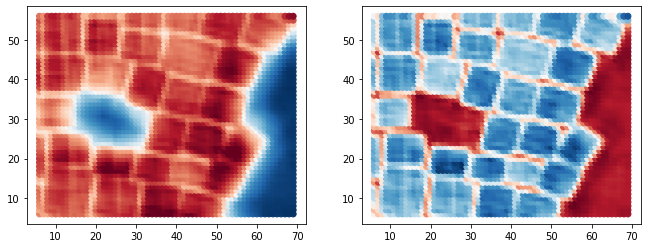

In [16]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [17]:
split_ = 30
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [18]:
dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp1.fit(X_train, y_train, training_cycles=100)

Epoch 1/100 ... Training loss: 0.768
Epoch 10/100 ... Training loss: 0.7272
Epoch 20/100 ... Training loss: 0.6866
Epoch 30/100 ... Training loss: 0.6481
Epoch 40/100 ... Training loss: 0.6064
Epoch 50/100 ... Training loss: 0.5645
Epoch 60/100 ... Training loss: 0.5183
Epoch 70/100 ... Training loss: 0.4775
Epoch 80/100 ... Training loss: 0.4319
Epoch 90/100 ... Training loss: 0.3884
Epoch 100/100 ... Training loss: 0.3418


Make a prediction on all the data:

In [19]:
mean, var = dklgp1.predict(X, batch_size=len(X))

Plot the prediction. The dotted vertical line divides the part used for training (left hand side) from the testing (right hand side) part.

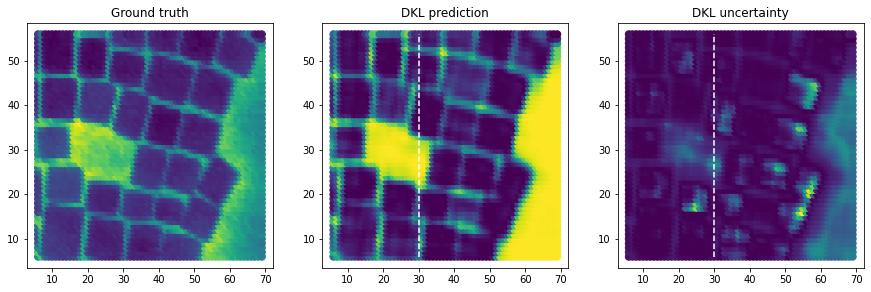

In [20]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just three "measured" points:

In [36]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.999, shuffle=True, random_state=4)

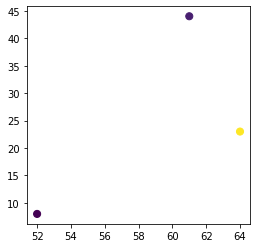

In [37]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40
Epoch 1/200 ... Training loss: 1.0305
Epoch 10/200 ... Training loss: 0.9912
Epoch 20/200 ... Training loss: 0.9114
Epoch 30/200 ... Training loss: 0.848
Epoch 40/200 ... Training loss: 0.7916
Epoch 50/200 ... Training loss: 0.7366
Epoch 60/200 ... Training loss: 0.684
Epoch 70/200 ... Training loss: 0.6338
Epoch 80/200 ... Training loss: 0.585
Epoch 90/200 ... Training loss: 0.5366
Epoch 100/200 ... Training loss: 0.4885
Epoch 110/200 ... Training loss: 0.4408
Epoch 120/200 ... Training loss: 0.3938
Epoch 130/200 ... Training loss: 0.3475
Epoch 140/200 ... Training loss: 0.302
Epoch 150/200 ... Training loss: 0.2577
Epoch 160/200 ... Training loss: 0.2146
Epoch 170/200 ... Training loss: 0.1729
Epoch 180/200 ... Training loss: 0.1327
Epoch 190/200 ... Training loss: 0.0942
Epoch 200/200 ... Training loss: 0.057


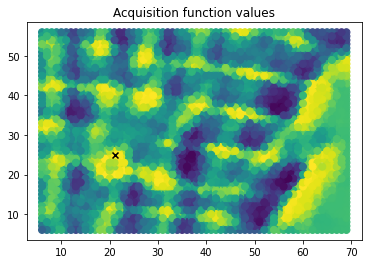

2/40
Epoch 1/200 ... Training loss: 1.0295
Epoch 10/200 ... Training loss: 0.9787
Epoch 20/200 ... Training loss: 0.9096
Epoch 30/200 ... Training loss: 0.854
Epoch 40/200 ... Training loss: 0.7967
Epoch 50/200 ... Training loss: 0.7418
Epoch 60/200 ... Training loss: 0.6888
Epoch 70/200 ... Training loss: 0.638
Epoch 80/200 ... Training loss: 0.5907
Epoch 90/200 ... Training loss: 0.5442
Epoch 100/200 ... Training loss: 0.4989
Epoch 110/200 ... Training loss: 0.4545
Epoch 120/200 ... Training loss: 0.4109
Epoch 130/200 ... Training loss: 0.3679
Epoch 140/200 ... Training loss: 0.3251
Epoch 150/200 ... Training loss: 0.2819
Epoch 160/200 ... Training loss: 0.239
Epoch 170/200 ... Training loss: 0.1885
Epoch 180/200 ... Training loss: 0.1479
Epoch 190/200 ... Training loss: 0.111
Epoch 200/200 ... Training loss: 0.0766


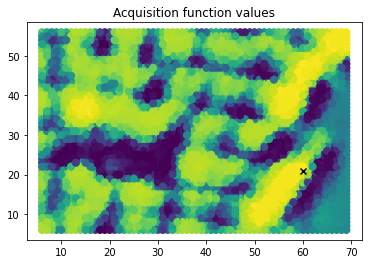

3/40
Epoch 1/200 ... Training loss: 0.9909
Epoch 10/200 ... Training loss: 0.9414
Epoch 20/200 ... Training loss: 0.8919
Epoch 30/200 ... Training loss: 0.8313
Epoch 40/200 ... Training loss: 0.7782
Epoch 50/200 ... Training loss: 0.7274
Epoch 60/200 ... Training loss: 0.6795
Epoch 70/200 ... Training loss: 0.6337
Epoch 80/200 ... Training loss: 0.5893
Epoch 90/200 ... Training loss: 0.5456
Epoch 100/200 ... Training loss: 0.5024
Epoch 110/200 ... Training loss: 0.4598
Epoch 120/200 ... Training loss: 0.4181
Epoch 130/200 ... Training loss: 0.3764
Epoch 140/200 ... Training loss: 0.3326
Epoch 150/200 ... Training loss: 0.2857
Epoch 160/200 ... Training loss: 0.2373
Epoch 170/200 ... Training loss: 0.1916
Epoch 180/200 ... Training loss: 0.1513
Epoch 190/200 ... Training loss: 0.1146
Epoch 200/200 ... Training loss: 0.08


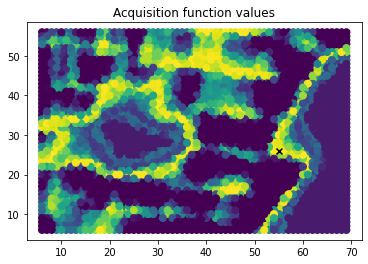

4/40
Epoch 1/200 ... Training loss: 0.9709
Epoch 10/200 ... Training loss: 0.9301
Epoch 20/200 ... Training loss: 0.8758
Epoch 30/200 ... Training loss: 0.823
Epoch 40/200 ... Training loss: 0.772
Epoch 50/200 ... Training loss: 0.7244
Epoch 60/200 ... Training loss: 0.6801
Epoch 70/200 ... Training loss: 0.6369
Epoch 80/200 ... Training loss: 0.5942
Epoch 90/200 ... Training loss: 0.5517
Epoch 100/200 ... Training loss: 0.5095
Epoch 110/200 ... Training loss: 0.4672
Epoch 120/200 ... Training loss: 0.425
Epoch 130/200 ... Training loss: 0.3831
Epoch 140/200 ... Training loss: 0.3416
Epoch 150/200 ... Training loss: 0.2989
Epoch 160/200 ... Training loss: 0.2545
Epoch 170/200 ... Training loss: 0.2095
Epoch 180/200 ... Training loss: 0.1716
Epoch 190/200 ... Training loss: 0.1364
Epoch 200/200 ... Training loss: 0.1033


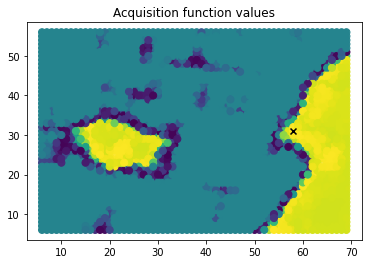

5/40
Epoch 1/200 ... Training loss: 0.9597
Epoch 10/200 ... Training loss: 0.9191
Epoch 20/200 ... Training loss: 0.8673
Epoch 30/200 ... Training loss: 0.8131
Epoch 40/200 ... Training loss: 0.7639
Epoch 50/200 ... Training loss: 0.7165
Epoch 60/200 ... Training loss: 0.6715
Epoch 70/200 ... Training loss: 0.628
Epoch 80/200 ... Training loss: 0.5851
Epoch 90/200 ... Training loss: 0.5421
Epoch 100/200 ... Training loss: 0.499
Epoch 110/200 ... Training loss: 0.4556
Epoch 120/200 ... Training loss: 0.4124
Epoch 130/200 ... Training loss: 0.3677
Epoch 140/200 ... Training loss: 0.3211
Epoch 150/200 ... Training loss: 0.2726
Epoch 160/200 ... Training loss: 0.2294
Epoch 170/200 ... Training loss: 0.1896
Epoch 180/200 ... Training loss: 0.1515
Epoch 190/200 ... Training loss: 0.1151
Epoch 200/200 ... Training loss: 0.0802


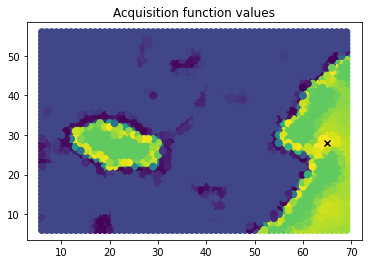

6/40
Epoch 1/200 ... Training loss: 0.9444
Epoch 10/200 ... Training loss: 0.938
Epoch 20/200 ... Training loss: 0.8591
Epoch 30/200 ... Training loss: 0.805
Epoch 40/200 ... Training loss: 0.7543
Epoch 50/200 ... Training loss: 0.7058
Epoch 60/200 ... Training loss: 0.6591
Epoch 70/200 ... Training loss: 0.6138
Epoch 80/200 ... Training loss: 0.5694
Epoch 90/200 ... Training loss: 0.5249
Epoch 100/200 ... Training loss: 0.48
Epoch 110/200 ... Training loss: 0.4345
Epoch 120/200 ... Training loss: 0.3882
Epoch 130/200 ... Training loss: 0.341
Epoch 140/200 ... Training loss: 0.294
Epoch 150/200 ... Training loss: 0.2494
Epoch 160/200 ... Training loss: 0.2076
Epoch 170/200 ... Training loss: 0.167
Epoch 180/200 ... Training loss: 0.128
Epoch 190/200 ... Training loss: 0.0905
Epoch 200/200 ... Training loss: 0.0544


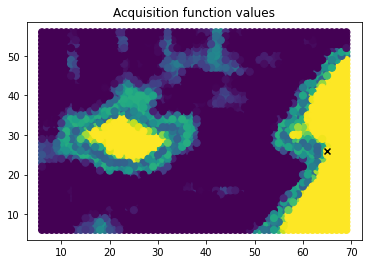

7/40
Epoch 1/200 ... Training loss: 0.9294
Epoch 10/200 ... Training loss: 0.8962
Epoch 20/200 ... Training loss: 0.8477
Epoch 30/200 ... Training loss: 0.7954
Epoch 40/200 ... Training loss: 0.7481
Epoch 50/200 ... Training loss: 0.695
Epoch 60/200 ... Training loss: 0.6482
Epoch 70/200 ... Training loss: 0.6029
Epoch 80/200 ... Training loss: 0.5588
Epoch 90/200 ... Training loss: 0.5148
Epoch 100/200 ... Training loss: 0.4703
Epoch 110/200 ... Training loss: 0.427
Epoch 120/200 ... Training loss: 0.3819
Epoch 130/200 ... Training loss: 0.3355
Epoch 140/200 ... Training loss: 0.2884
Epoch 150/200 ... Training loss: 0.244
Epoch 160/200 ... Training loss: 0.1999
Epoch 170/200 ... Training loss: 0.1574
Epoch 180/200 ... Training loss: 0.1164
Epoch 190/200 ... Training loss: 0.077
Epoch 200/200 ... Training loss: 0.0393


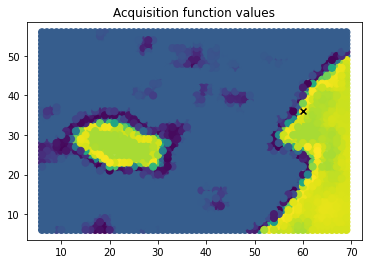

8/40
Epoch 1/200 ... Training loss: 0.9177
Epoch 10/200 ... Training loss: 0.883
Epoch 20/200 ... Training loss: 0.8316
Epoch 30/200 ... Training loss: 0.7831
Epoch 40/200 ... Training loss: 0.7333
Epoch 50/200 ... Training loss: 0.6914
Epoch 60/200 ... Training loss: 0.6411
Epoch 70/200 ... Training loss: 0.5951
Epoch 80/200 ... Training loss: 0.5509
Epoch 90/200 ... Training loss: 0.5069
Epoch 100/200 ... Training loss: 0.4626
Epoch 110/200 ... Training loss: 0.4181
Epoch 120/200 ... Training loss: 0.3735
Epoch 130/200 ... Training loss: 0.3288
Epoch 140/200 ... Training loss: 0.2841
Epoch 150/200 ... Training loss: 0.2398
Epoch 160/200 ... Training loss: 0.1954
Epoch 170/200 ... Training loss: 0.1498
Epoch 180/200 ... Training loss: 0.1062
Epoch 190/200 ... Training loss: 0.0655
Epoch 200/200 ... Training loss: 0.0261


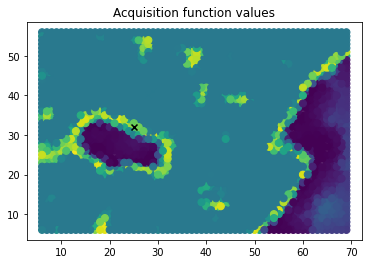

9/40
Epoch 1/200 ... Training loss: 0.9141
Epoch 10/200 ... Training loss: 0.888
Epoch 20/200 ... Training loss: 0.8291
Epoch 30/200 ... Training loss: 0.7795
Epoch 40/200 ... Training loss: 0.7285
Epoch 50/200 ... Training loss: 0.6808
Epoch 60/200 ... Training loss: 0.6347
Epoch 70/200 ... Training loss: 0.5894
Epoch 80/200 ... Training loss: 0.5445
Epoch 90/200 ... Training loss: 0.4999
Epoch 100/200 ... Training loss: 0.455
Epoch 110/200 ... Training loss: 0.4099
Epoch 120/200 ... Training loss: 0.3649
Epoch 130/200 ... Training loss: 0.3205
Epoch 140/200 ... Training loss: 0.2747
Epoch 150/200 ... Training loss: 0.2281
Epoch 160/200 ... Training loss: 0.182
Epoch 170/200 ... Training loss: 0.1379
Epoch 180/200 ... Training loss: 0.0949
Epoch 190/200 ... Training loss: 0.0539
Epoch 200/200 ... Training loss: 0.0142


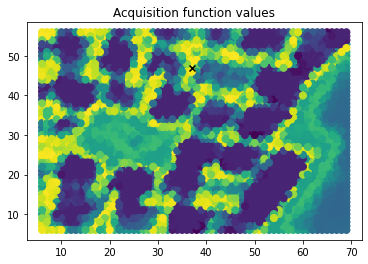

10/40
Epoch 1/200 ... Training loss: 0.9045
Epoch 10/200 ... Training loss: 0.8738
Epoch 20/200 ... Training loss: 0.8214
Epoch 30/200 ... Training loss: 0.7702
Epoch 40/200 ... Training loss: 0.7212
Epoch 50/200 ... Training loss: 0.6749
Epoch 60/200 ... Training loss: 0.6319
Epoch 70/200 ... Training loss: 0.5863
Epoch 80/200 ... Training loss: 0.5421
Epoch 90/200 ... Training loss: 0.4979
Epoch 100/200 ... Training loss: 0.4531
Epoch 110/200 ... Training loss: 0.4078
Epoch 120/200 ... Training loss: 0.3621
Epoch 130/200 ... Training loss: 0.3161
Epoch 140/200 ... Training loss: 0.2699
Epoch 150/200 ... Training loss: 0.2237
Epoch 160/200 ... Training loss: 0.1777
Epoch 170/200 ... Training loss: 0.1331
Epoch 180/200 ... Training loss: 0.0908
Epoch 190/200 ... Training loss: 0.0495
Epoch 200/200 ... Training loss: 0.0092


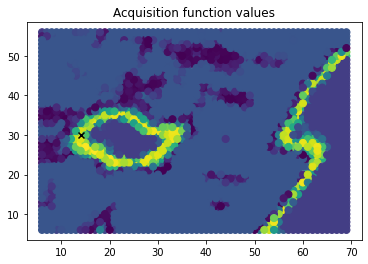

11/40
Epoch 1/200 ... Training loss: 0.8961
Epoch 10/200 ... Training loss: 0.8625
Epoch 20/200 ... Training loss: 0.8137
Epoch 30/200 ... Training loss: 0.7801
Epoch 40/200 ... Training loss: 0.7219
Epoch 50/200 ... Training loss: 0.6745
Epoch 60/200 ... Training loss: 0.6286
Epoch 70/200 ... Training loss: 0.5842
Epoch 80/200 ... Training loss: 0.5403
Epoch 90/200 ... Training loss: 0.4963
Epoch 100/200 ... Training loss: 0.452
Epoch 110/200 ... Training loss: 0.4075
Epoch 120/200 ... Training loss: 0.3627
Epoch 130/200 ... Training loss: 0.3176
Epoch 140/200 ... Training loss: 0.2726
Epoch 150/200 ... Training loss: 0.2283
Epoch 160/200 ... Training loss: 0.1819
Epoch 170/200 ... Training loss: 0.1354
Epoch 180/200 ... Training loss: 0.0893
Epoch 190/200 ... Training loss: 0.0454
Epoch 200/200 ... Training loss: 0.0033


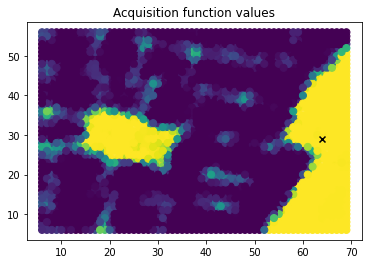

12/40
Epoch 1/200 ... Training loss: 0.8889
Epoch 10/200 ... Training loss: 0.868
Epoch 20/200 ... Training loss: 0.8243
Epoch 30/200 ... Training loss: 0.7618
Epoch 40/200 ... Training loss: 0.7143
Epoch 50/200 ... Training loss: 0.6689
Epoch 60/200 ... Training loss: 0.6307
Epoch 70/200 ... Training loss: 0.5798
Epoch 80/200 ... Training loss: 0.5349
Epoch 90/200 ... Training loss: 0.4902
Epoch 100/200 ... Training loss: 0.4453
Epoch 110/200 ... Training loss: 0.4001
Epoch 120/200 ... Training loss: 0.3544
Epoch 130/200 ... Training loss: 0.3083
Epoch 140/200 ... Training loss: 0.2616
Epoch 150/200 ... Training loss: 0.2141
Epoch 160/200 ... Training loss: 0.165
Epoch 170/200 ... Training loss: 0.1198
Epoch 180/200 ... Training loss: 0.0756
Epoch 190/200 ... Training loss: 0.0323
Epoch 200/200 ... Training loss: -0.0099


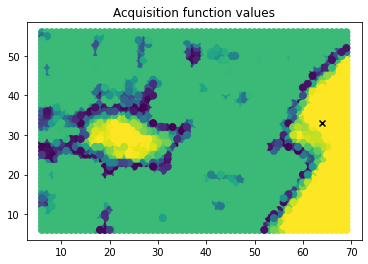

13/40
Epoch 1/200 ... Training loss: 0.8836
Epoch 10/200 ... Training loss: 0.8608
Epoch 20/200 ... Training loss: 0.8073
Epoch 30/200 ... Training loss: 0.7573
Epoch 40/200 ... Training loss: 0.7099
Epoch 50/200 ... Training loss: 0.6639
Epoch 60/200 ... Training loss: 0.6188
Epoch 70/200 ... Training loss: 0.5741
Epoch 80/200 ... Training loss: 0.5289
Epoch 90/200 ... Training loss: 0.4829
Epoch 100/200 ... Training loss: 0.4385
Epoch 110/200 ... Training loss: 0.3932
Epoch 120/200 ... Training loss: 0.3471
Epoch 130/200 ... Training loss: 0.3005
Epoch 140/200 ... Training loss: 0.2537
Epoch 150/200 ... Training loss: 0.2078
Epoch 160/200 ... Training loss: 0.1607
Epoch 170/200 ... Training loss: 0.114
Epoch 180/200 ... Training loss: 0.0695
Epoch 190/200 ... Training loss: 0.026
Epoch 200/200 ... Training loss: -0.0166


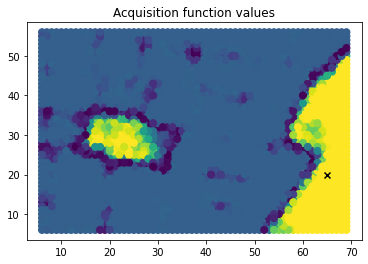

14/40
Epoch 1/200 ... Training loss: 0.8769
Epoch 10/200 ... Training loss: 0.8519
Epoch 20/200 ... Training loss: 0.8021
Epoch 30/200 ... Training loss: 0.7515
Epoch 40/200 ... Training loss: 0.7046
Epoch 50/200 ... Training loss: 0.6587
Epoch 60/200 ... Training loss: 0.6138
Epoch 70/200 ... Training loss: 0.5698
Epoch 80/200 ... Training loss: 0.526
Epoch 90/200 ... Training loss: 0.4816
Epoch 100/200 ... Training loss: 0.4364
Epoch 110/200 ... Training loss: 0.3908
Epoch 120/200 ... Training loss: 0.3447
Epoch 130/200 ... Training loss: 0.2982
Epoch 140/200 ... Training loss: 0.2514
Epoch 150/200 ... Training loss: 0.2038
Epoch 160/200 ... Training loss: 0.1558
Epoch 170/200 ... Training loss: 0.1096
Epoch 180/200 ... Training loss: 0.0645
Epoch 190/200 ... Training loss: 0.0205
Epoch 200/200 ... Training loss: -0.0225


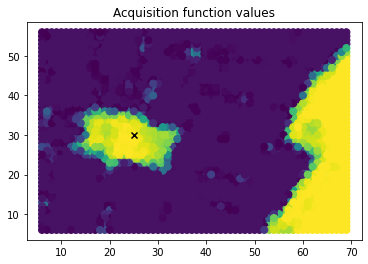

15/40
Epoch 1/200 ... Training loss: 0.873
Epoch 10/200 ... Training loss: 0.8504
Epoch 20/200 ... Training loss: 0.7942
Epoch 30/200 ... Training loss: 0.7457
Epoch 40/200 ... Training loss: 0.6997
Epoch 50/200 ... Training loss: 0.6548
Epoch 60/200 ... Training loss: 0.6104
Epoch 70/200 ... Training loss: 0.5663
Epoch 80/200 ... Training loss: 0.5218
Epoch 90/200 ... Training loss: 0.4769
Epoch 100/200 ... Training loss: 0.4314
Epoch 110/200 ... Training loss: 0.3856
Epoch 120/200 ... Training loss: 0.3397
Epoch 130/200 ... Training loss: 0.2931
Epoch 140/200 ... Training loss: 0.2467
Epoch 150/200 ... Training loss: 0.2025
Epoch 160/200 ... Training loss: 0.155
Epoch 170/200 ... Training loss: 0.1091
Epoch 180/200 ... Training loss: 0.0636
Epoch 190/200 ... Training loss: 0.0189
Epoch 200/200 ... Training loss: -0.025


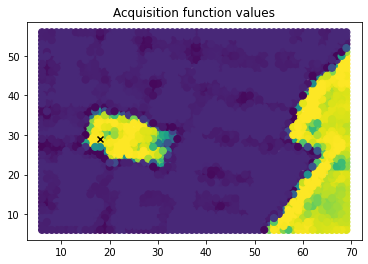

16/40
Epoch 1/200 ... Training loss: 0.8714
Epoch 10/200 ... Training loss: 0.8475
Epoch 20/200 ... Training loss: 0.7915
Epoch 30/200 ... Training loss: 0.7437
Epoch 40/200 ... Training loss: 0.6988
Epoch 50/200 ... Training loss: 0.6579
Epoch 60/200 ... Training loss: 0.6099
Epoch 70/200 ... Training loss: 0.5713
Epoch 80/200 ... Training loss: 0.5213
Epoch 90/200 ... Training loss: 0.4767
Epoch 100/200 ... Training loss: 0.4319
Epoch 110/200 ... Training loss: 0.3867
Epoch 120/200 ... Training loss: 0.3411
Epoch 130/200 ... Training loss: 0.2951
Epoch 140/200 ... Training loss: 0.2488
Epoch 150/200 ... Training loss: 0.2021
Epoch 160/200 ... Training loss: 0.1565
Epoch 170/200 ... Training loss: 0.1093
Epoch 180/200 ... Training loss: 0.0641
Epoch 190/200 ... Training loss: 0.0192
Epoch 200/200 ... Training loss: -0.0248


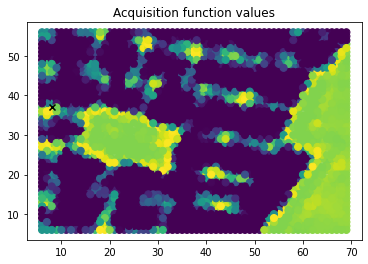

17/40
Epoch 1/200 ... Training loss: 0.8699
Epoch 10/200 ... Training loss: 0.842
Epoch 20/200 ... Training loss: 0.7957
Epoch 30/200 ... Training loss: 0.7485
Epoch 40/200 ... Training loss: 0.6983
Epoch 50/200 ... Training loss: 0.6515
Epoch 60/200 ... Training loss: 0.6059
Epoch 70/200 ... Training loss: 0.5607
Epoch 80/200 ... Training loss: 0.5158
Epoch 90/200 ... Training loss: 0.4704
Epoch 100/200 ... Training loss: 0.4244
Epoch 110/200 ... Training loss: 0.3781
Epoch 120/200 ... Training loss: 0.3317
Epoch 130/200 ... Training loss: 0.2852
Epoch 140/200 ... Training loss: 0.2394
Epoch 150/200 ... Training loss: 0.1935
Epoch 160/200 ... Training loss: 0.1478
Epoch 170/200 ... Training loss: 0.1019
Epoch 180/200 ... Training loss: 0.0567
Epoch 190/200 ... Training loss: 0.0116
Epoch 200/200 ... Training loss: -0.0329


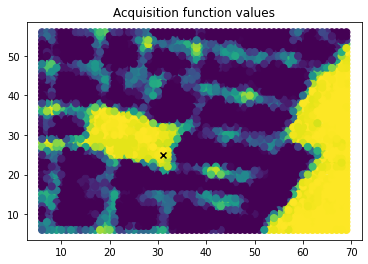

18/40
Epoch 1/200 ... Training loss: 0.8669
Epoch 10/200 ... Training loss: 0.8435
Epoch 20/200 ... Training loss: 0.7933
Epoch 30/200 ... Training loss: 0.7443
Epoch 40/200 ... Training loss: 0.6959
Epoch 50/200 ... Training loss: 0.6485
Epoch 60/200 ... Training loss: 0.6026
Epoch 70/200 ... Training loss: 0.558
Epoch 80/200 ... Training loss: 0.5171
Epoch 90/200 ... Training loss: 0.4685
Epoch 100/200 ... Training loss: 0.4228
Epoch 110/200 ... Training loss: 0.3767
Epoch 120/200 ... Training loss: 0.3303
Epoch 130/200 ... Training loss: 0.2837
Epoch 140/200 ... Training loss: 0.2371
Epoch 150/200 ... Training loss: 0.1906
Epoch 160/200 ... Training loss: 0.1442
Epoch 170/200 ... Training loss: 0.0979
Epoch 180/200 ... Training loss: 0.052
Epoch 190/200 ... Training loss: 0.0067
Epoch 200/200 ... Training loss: -0.0378


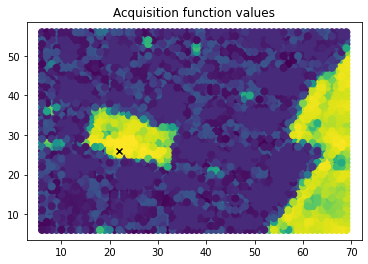

19/40
Epoch 1/200 ... Training loss: 0.8656
Epoch 10/200 ... Training loss: 0.8385
Epoch 20/200 ... Training loss: 0.7896
Epoch 30/200 ... Training loss: 0.7402
Epoch 40/200 ... Training loss: 0.6918
Epoch 50/200 ... Training loss: 0.6446
Epoch 60/200 ... Training loss: 0.6028
Epoch 70/200 ... Training loss: 0.5582
Epoch 80/200 ... Training loss: 0.5123
Epoch 90/200 ... Training loss: 0.4676
Epoch 100/200 ... Training loss: 0.4227
Epoch 110/200 ... Training loss: 0.3768
Epoch 120/200 ... Training loss: 0.3307
Epoch 130/200 ... Training loss: 0.2843
Epoch 140/200 ... Training loss: 0.2392
Epoch 150/200 ... Training loss: 0.1919
Epoch 160/200 ... Training loss: 0.1449
Epoch 170/200 ... Training loss: 0.0985
Epoch 180/200 ... Training loss: 0.0528
Epoch 190/200 ... Training loss: 0.0075
Epoch 200/200 ... Training loss: -0.037


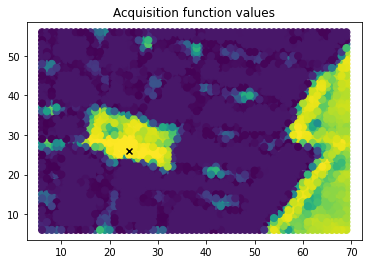

20/40
Epoch 1/200 ... Training loss: 0.864
Epoch 10/200 ... Training loss: 0.8347
Epoch 20/200 ... Training loss: 0.7872
Epoch 30/200 ... Training loss: 0.7375
Epoch 40/200 ... Training loss: 0.6892
Epoch 50/200 ... Training loss: 0.643
Epoch 60/200 ... Training loss: 0.5978
Epoch 70/200 ... Training loss: 0.5531
Epoch 80/200 ... Training loss: 0.5082
Epoch 90/200 ... Training loss: 0.4645
Epoch 100/200 ... Training loss: 0.4188
Epoch 110/200 ... Training loss: 0.3725
Epoch 120/200 ... Training loss: 0.3262
Epoch 130/200 ... Training loss: 0.2797
Epoch 140/200 ... Training loss: 0.2334
Epoch 150/200 ... Training loss: 0.1869
Epoch 160/200 ... Training loss: 0.1409
Epoch 170/200 ... Training loss: 0.0952
Epoch 180/200 ... Training loss: 0.0493
Epoch 190/200 ... Training loss: 0.0037
Epoch 200/200 ... Training loss: -0.0409


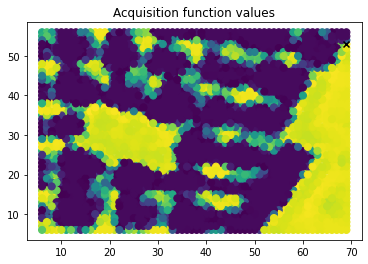

21/40
Epoch 1/200 ... Training loss: 0.8617
Epoch 10/200 ... Training loss: 0.83
Epoch 20/200 ... Training loss: 0.7837
Epoch 30/200 ... Training loss: 0.7353
Epoch 40/200 ... Training loss: 0.6872
Epoch 50/200 ... Training loss: 0.6395
Epoch 60/200 ... Training loss: 0.5983
Epoch 70/200 ... Training loss: 0.5543
Epoch 80/200 ... Training loss: 0.5087
Epoch 90/200 ... Training loss: 0.4627
Epoch 100/200 ... Training loss: 0.4172
Epoch 110/200 ... Training loss: 0.371
Epoch 120/200 ... Training loss: 0.3245
Epoch 130/200 ... Training loss: 0.2779
Epoch 140/200 ... Training loss: 0.2313
Epoch 150/200 ... Training loss: 0.1847
Epoch 160/200 ... Training loss: 0.1383
Epoch 170/200 ... Training loss: 0.0925
Epoch 180/200 ... Training loss: 0.0471
Epoch 190/200 ... Training loss: 0.0019
Epoch 200/200 ... Training loss: -0.0427


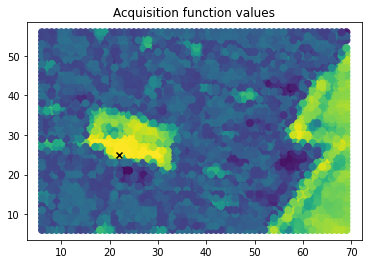

22/40
Epoch 1/200 ... Training loss: 0.8597
Epoch 10/200 ... Training loss: 0.8252
Epoch 20/200 ... Training loss: 0.7798
Epoch 30/200 ... Training loss: 0.7342
Epoch 40/200 ... Training loss: 0.6869
Epoch 50/200 ... Training loss: 0.641
Epoch 60/200 ... Training loss: 0.5955
Epoch 70/200 ... Training loss: 0.5501
Epoch 80/200 ... Training loss: 0.5051
Epoch 90/200 ... Training loss: 0.46
Epoch 100/200 ... Training loss: 0.4141
Epoch 110/200 ... Training loss: 0.3677
Epoch 120/200 ... Training loss: 0.3213
Epoch 130/200 ... Training loss: 0.275
Epoch 140/200 ... Training loss: 0.2295
Epoch 150/200 ... Training loss: 0.1837
Epoch 160/200 ... Training loss: 0.137
Epoch 170/200 ... Training loss: 0.0906
Epoch 180/200 ... Training loss: 0.0449
Epoch 190/200 ... Training loss: -0.0003
Epoch 200/200 ... Training loss: -0.0451


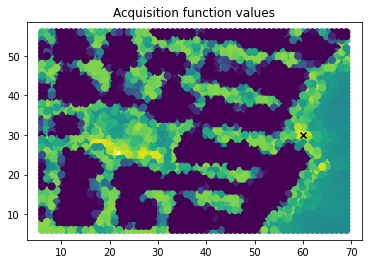

23/40
Epoch 1/200 ... Training loss: 0.8564
Epoch 10/200 ... Training loss: 0.8217
Epoch 20/200 ... Training loss: 0.7715
Epoch 30/200 ... Training loss: 0.7258
Epoch 40/200 ... Training loss: 0.6803
Epoch 50/200 ... Training loss: 0.6349
Epoch 60/200 ... Training loss: 0.5899
Epoch 70/200 ... Training loss: 0.5452
Epoch 80/200 ... Training loss: 0.5005
Epoch 90/200 ... Training loss: 0.4596
Epoch 100/200 ... Training loss: 0.413
Epoch 110/200 ... Training loss: 0.367
Epoch 120/200 ... Training loss: 0.3207
Epoch 130/200 ... Training loss: 0.2743
Epoch 140/200 ... Training loss: 0.2279
Epoch 150/200 ... Training loss: 0.1815
Epoch 160/200 ... Training loss: 0.1355
Epoch 170/200 ... Training loss: 0.0901
Epoch 180/200 ... Training loss: 0.045
Epoch 190/200 ... Training loss: -0.001
Epoch 200/200 ... Training loss: -0.0464


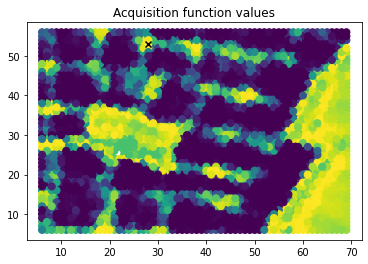

24/40
Epoch 1/200 ... Training loss: 0.8537
Epoch 10/200 ... Training loss: 0.8169
Epoch 20/200 ... Training loss: 0.7738
Epoch 30/200 ... Training loss: 0.7256
Epoch 40/200 ... Training loss: 0.6786
Epoch 50/200 ... Training loss: 0.6331
Epoch 60/200 ... Training loss: 0.5886
Epoch 70/200 ... Training loss: 0.5445
Epoch 80/200 ... Training loss: 0.5001
Epoch 90/200 ... Training loss: 0.4553
Epoch 100/200 ... Training loss: 0.4099
Epoch 110/200 ... Training loss: 0.3649
Epoch 120/200 ... Training loss: 0.3188
Epoch 130/200 ... Training loss: 0.2724
Epoch 140/200 ... Training loss: 0.2258
Epoch 150/200 ... Training loss: 0.1793
Epoch 160/200 ... Training loss: 0.1331
Epoch 170/200 ... Training loss: 0.0875
Epoch 180/200 ... Training loss: 0.0419
Epoch 190/200 ... Training loss: -0.004
Epoch 200/200 ... Training loss: -0.0496


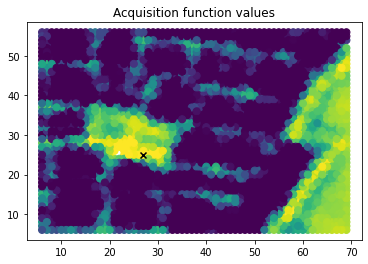

25/40
Epoch 1/200 ... Training loss: 0.8517
Epoch 10/200 ... Training loss: 0.8191
Epoch 20/200 ... Training loss: 0.7665
Epoch 30/200 ... Training loss: 0.7211
Epoch 40/200 ... Training loss: 0.6762
Epoch 50/200 ... Training loss: 0.6314
Epoch 60/200 ... Training loss: 0.5867
Epoch 70/200 ... Training loss: 0.5422
Epoch 80/200 ... Training loss: 0.4977
Epoch 90/200 ... Training loss: 0.4571
Epoch 100/200 ... Training loss: 0.4104
Epoch 110/200 ... Training loss: 0.3638
Epoch 120/200 ... Training loss: 0.3176
Epoch 130/200 ... Training loss: 0.271
Epoch 140/200 ... Training loss: 0.2242
Epoch 150/200 ... Training loss: 0.1776
Epoch 160/200 ... Training loss: 0.1315
Epoch 170/200 ... Training loss: 0.0855
Epoch 180/200 ... Training loss: 0.0398
Epoch 190/200 ... Training loss: -0.0068
Epoch 200/200 ... Training loss: -0.0527


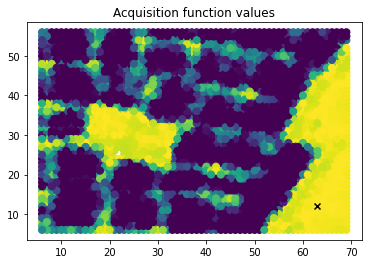

26/40
Epoch 1/200 ... Training loss: 0.8494
Epoch 10/200 ... Training loss: 0.8155
Epoch 20/200 ... Training loss: 0.7664
Epoch 30/200 ... Training loss: 0.7212
Epoch 40/200 ... Training loss: 0.6763
Epoch 50/200 ... Training loss: 0.631
Epoch 60/200 ... Training loss: 0.5855
Epoch 70/200 ... Training loss: 0.5441
Epoch 80/200 ... Training loss: 0.499
Epoch 90/200 ... Training loss: 0.4538
Epoch 100/200 ... Training loss: 0.4082
Epoch 110/200 ... Training loss: 0.3621
Epoch 120/200 ... Training loss: 0.3154
Epoch 130/200 ... Training loss: 0.2685
Epoch 140/200 ... Training loss: 0.2222
Epoch 150/200 ... Training loss: 0.1775
Epoch 160/200 ... Training loss: 0.13
Epoch 170/200 ... Training loss: 0.083
Epoch 180/200 ... Training loss: 0.0364
Epoch 190/200 ... Training loss: -0.0098
Epoch 200/200 ... Training loss: -0.0557


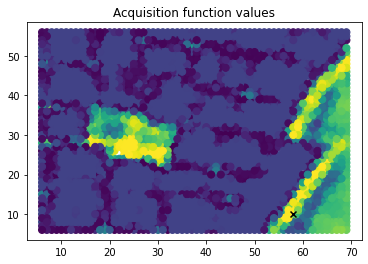

27/40
Epoch 1/200 ... Training loss: 0.8471
Epoch 10/200 ... Training loss: 0.8145
Epoch 20/200 ... Training loss: 0.7641
Epoch 30/200 ... Training loss: 0.7182
Epoch 40/200 ... Training loss: 0.6735
Epoch 50/200 ... Training loss: 0.6288
Epoch 60/200 ... Training loss: 0.5838
Epoch 70/200 ... Training loss: 0.5394
Epoch 80/200 ... Training loss: 0.4947
Epoch 90/200 ... Training loss: 0.4492
Epoch 100/200 ... Training loss: 0.4036
Epoch 110/200 ... Training loss: 0.3579
Epoch 120/200 ... Training loss: 0.3118
Epoch 130/200 ... Training loss: 0.2654
Epoch 140/200 ... Training loss: 0.2188
Epoch 150/200 ... Training loss: 0.1723
Epoch 160/200 ... Training loss: 0.1258
Epoch 170/200 ... Training loss: 0.0797
Epoch 180/200 ... Training loss: 0.0343
Epoch 190/200 ... Training loss: -0.0111
Epoch 200/200 ... Training loss: -0.0548


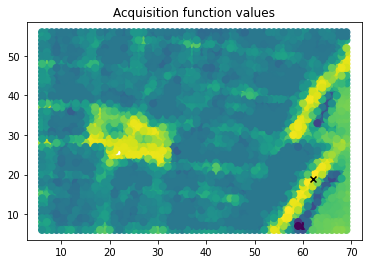

28/40
Epoch 1/200 ... Training loss: 0.8443
Epoch 10/200 ... Training loss: 0.812
Epoch 20/200 ... Training loss: 0.7622
Epoch 30/200 ... Training loss: 0.7166
Epoch 40/200 ... Training loss: 0.6718
Epoch 50/200 ... Training loss: 0.6279
Epoch 60/200 ... Training loss: 0.5823
Epoch 70/200 ... Training loss: 0.5379
Epoch 80/200 ... Training loss: 0.4935
Epoch 90/200 ... Training loss: 0.4486
Epoch 100/200 ... Training loss: 0.403
Epoch 110/200 ... Training loss: 0.3569
Epoch 120/200 ... Training loss: 0.3105
Epoch 130/200 ... Training loss: 0.2639
Epoch 140/200 ... Training loss: 0.2197
Epoch 150/200 ... Training loss: 0.1735
Epoch 160/200 ... Training loss: 0.1257
Epoch 170/200 ... Training loss: 0.0787
Epoch 180/200 ... Training loss: 0.0319
Epoch 190/200 ... Training loss: -0.0145
Epoch 200/200 ... Training loss: -0.0607


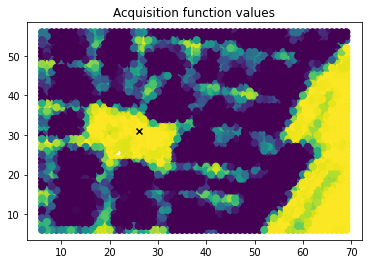

29/40
Epoch 1/200 ... Training loss: 0.8423
Epoch 10/200 ... Training loss: 0.8028
Epoch 20/200 ... Training loss: 0.7616
Epoch 30/200 ... Training loss: 0.7134
Epoch 40/200 ... Training loss: 0.6684
Epoch 50/200 ... Training loss: 0.6237
Epoch 60/200 ... Training loss: 0.5794
Epoch 70/200 ... Training loss: 0.5366
Epoch 80/200 ... Training loss: 0.4918
Epoch 90/200 ... Training loss: 0.4469
Epoch 100/200 ... Training loss: 0.4013
Epoch 110/200 ... Training loss: 0.3554
Epoch 120/200 ... Training loss: 0.3094
Epoch 130/200 ... Training loss: 0.2633
Epoch 140/200 ... Training loss: 0.2174
Epoch 150/200 ... Training loss: 0.1712
Epoch 160/200 ... Training loss: 0.124
Epoch 170/200 ... Training loss: 0.0771
Epoch 180/200 ... Training loss: 0.0302
Epoch 190/200 ... Training loss: -0.0164
Epoch 200/200 ... Training loss: -0.0628


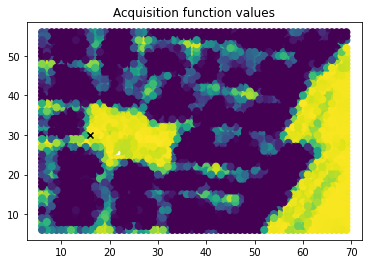

30/40
Epoch 1/200 ... Training loss: 0.8407
Epoch 10/200 ... Training loss: 0.8237
Epoch 20/200 ... Training loss: 0.7588
Epoch 30/200 ... Training loss: 0.7117
Epoch 40/200 ... Training loss: 0.6664
Epoch 50/200 ... Training loss: 0.6217
Epoch 60/200 ... Training loss: 0.5813
Epoch 70/200 ... Training loss: 0.5366
Epoch 80/200 ... Training loss: 0.4912
Epoch 90/200 ... Training loss: 0.4462
Epoch 100/200 ... Training loss: 0.4008
Epoch 110/200 ... Training loss: 0.3548
Epoch 120/200 ... Training loss: 0.3083
Epoch 130/200 ... Training loss: 0.2615
Epoch 140/200 ... Training loss: 0.2147
Epoch 150/200 ... Training loss: 0.1679
Epoch 160/200 ... Training loss: 0.1213
Epoch 170/200 ... Training loss: 0.0759
Epoch 180/200 ... Training loss: 0.0306
Epoch 190/200 ... Training loss: -0.0168
Epoch 200/200 ... Training loss: -0.0638


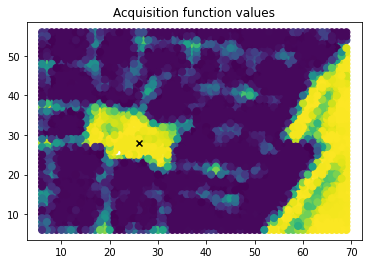

31/40
Epoch 1/200 ... Training loss: 0.8384
Epoch 10/200 ... Training loss: 0.8073
Epoch 20/200 ... Training loss: 0.7574
Epoch 30/200 ... Training loss: 0.7106
Epoch 40/200 ... Training loss: 0.666
Epoch 50/200 ... Training loss: 0.6214
Epoch 60/200 ... Training loss: 0.5767
Epoch 70/200 ... Training loss: 0.5323
Epoch 80/200 ... Training loss: 0.4933
Epoch 90/200 ... Training loss: 0.4481
Epoch 100/200 ... Training loss: 0.4011
Epoch 110/200 ... Training loss: 0.3546
Epoch 120/200 ... Training loss: 0.3083
Epoch 130/200 ... Training loss: 0.2616
Epoch 140/200 ... Training loss: 0.2145
Epoch 150/200 ... Training loss: 0.1675
Epoch 160/200 ... Training loss: 0.1204
Epoch 170/200 ... Training loss: 0.0735
Epoch 180/200 ... Training loss: 0.0266
Epoch 190/200 ... Training loss: -0.0205
Epoch 200/200 ... Training loss: -0.0672


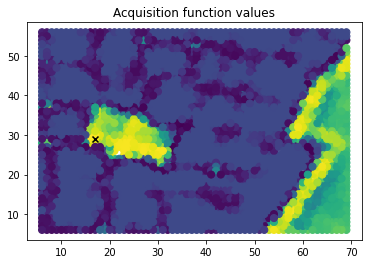

32/40
Epoch 1/200 ... Training loss: 0.8371
Epoch 10/200 ... Training loss: 0.7964
Epoch 20/200 ... Training loss: 0.755
Epoch 30/200 ... Training loss: 0.7112
Epoch 40/200 ... Training loss: 0.6654
Epoch 50/200 ... Training loss: 0.6198
Epoch 60/200 ... Training loss: 0.5757
Epoch 70/200 ... Training loss: 0.5353
Epoch 80/200 ... Training loss: 0.4899
Epoch 90/200 ... Training loss: 0.4445
Epoch 100/200 ... Training loss: 0.399
Epoch 110/200 ... Training loss: 0.353
Epoch 120/200 ... Training loss: 0.3066
Epoch 130/200 ... Training loss: 0.2598
Epoch 140/200 ... Training loss: 0.2129
Epoch 150/200 ... Training loss: 0.1658
Epoch 160/200 ... Training loss: 0.1188
Epoch 170/200 ... Training loss: 0.0719
Epoch 180/200 ... Training loss: 0.0252
Epoch 190/200 ... Training loss: -0.0214
Epoch 200/200 ... Training loss: -0.0679


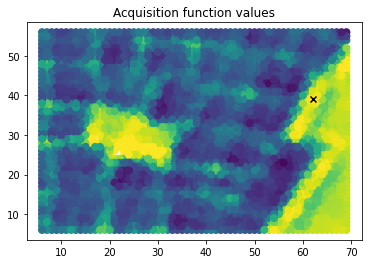

33/40
Epoch 1/200 ... Training loss: 0.8348
Epoch 10/200 ... Training loss: 0.8055
Epoch 20/200 ... Training loss: 0.7535
Epoch 30/200 ... Training loss: 0.7079
Epoch 40/200 ... Training loss: 0.6629
Epoch 50/200 ... Training loss: 0.6182
Epoch 60/200 ... Training loss: 0.5742
Epoch 70/200 ... Training loss: 0.5305
Epoch 80/200 ... Training loss: 0.4881
Epoch 90/200 ... Training loss: 0.4424
Epoch 100/200 ... Training loss: 0.3972
Epoch 110/200 ... Training loss: 0.3516
Epoch 120/200 ... Training loss: 0.3055
Epoch 130/200 ... Training loss: 0.2597
Epoch 140/200 ... Training loss: 0.2125
Epoch 150/200 ... Training loss: 0.1653
Epoch 160/200 ... Training loss: 0.1181
Epoch 170/200 ... Training loss: 0.0708
Epoch 180/200 ... Training loss: 0.0237
Epoch 190/200 ... Training loss: -0.0234
Epoch 200/200 ... Training loss: -0.0703


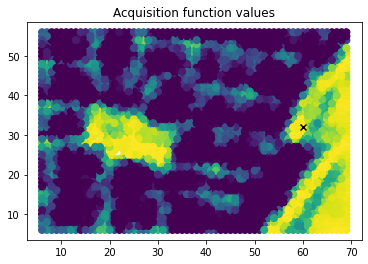

34/40
Epoch 1/200 ... Training loss: 0.8328
Epoch 10/200 ... Training loss: 0.7957
Epoch 20/200 ... Training loss: 0.7489
Epoch 30/200 ... Training loss: 0.7043
Epoch 40/200 ... Training loss: 0.6601
Epoch 50/200 ... Training loss: 0.6158
Epoch 60/200 ... Training loss: 0.5719
Epoch 70/200 ... Training loss: 0.5344
Epoch 80/200 ... Training loss: 0.4878
Epoch 90/200 ... Training loss: 0.4609
Epoch 100/200 ... Training loss: 0.3968
Epoch 110/200 ... Training loss: 0.3511
Epoch 120/200 ... Training loss: 0.3048
Epoch 130/200 ... Training loss: 0.2579
Epoch 140/200 ... Training loss: 0.2109
Epoch 150/200 ... Training loss: 0.1645
Epoch 160/200 ... Training loss: 0.1171
Epoch 170/200 ... Training loss: 0.0696
Epoch 180/200 ... Training loss: 0.0223
Epoch 190/200 ... Training loss: -0.0249
Epoch 200/200 ... Training loss: -0.072


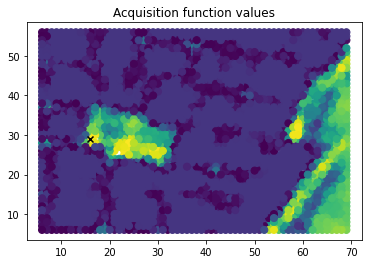

35/40
Epoch 1/200 ... Training loss: 0.8316
Epoch 10/200 ... Training loss: 0.7946
Epoch 20/200 ... Training loss: 0.7502
Epoch 30/200 ... Training loss: 0.7043
Epoch 40/200 ... Training loss: 0.6591
Epoch 50/200 ... Training loss: 0.6146
Epoch 60/200 ... Training loss: 0.5709
Epoch 70/200 ... Training loss: 0.5273
Epoch 80/200 ... Training loss: 0.4895
Epoch 90/200 ... Training loss: 0.4423
Epoch 100/200 ... Training loss: 0.3962
Epoch 110/200 ... Training loss: 0.3499
Epoch 120/200 ... Training loss: 0.3034
Epoch 130/200 ... Training loss: 0.2567
Epoch 140/200 ... Training loss: 0.2097
Epoch 150/200 ... Training loss: 0.1628
Epoch 160/200 ... Training loss: 0.1164
Epoch 170/200 ... Training loss: 0.0691
Epoch 180/200 ... Training loss: 0.0215
Epoch 190/200 ... Training loss: -0.0258
Epoch 200/200 ... Training loss: -0.0732


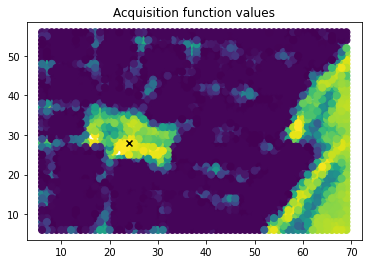

36/40
Epoch 1/200 ... Training loss: 0.8308
Epoch 10/200 ... Training loss: 0.7934
Epoch 20/200 ... Training loss: 0.7481
Epoch 30/200 ... Training loss: 0.7026
Epoch 40/200 ... Training loss: 0.6573
Epoch 50/200 ... Training loss: 0.6134
Epoch 60/200 ... Training loss: 0.5699
Epoch 70/200 ... Training loss: 0.526
Epoch 80/200 ... Training loss: 0.4817
Epoch 90/200 ... Training loss: 0.4367
Epoch 100/200 ... Training loss: 0.3966
Epoch 110/200 ... Training loss: 0.3522
Epoch 120/200 ... Training loss: 0.3042
Epoch 130/200 ... Training loss: 0.2571
Epoch 140/200 ... Training loss: 0.2097
Epoch 150/200 ... Training loss: 0.1622
Epoch 160/200 ... Training loss: 0.1148
Epoch 170/200 ... Training loss: 0.0673
Epoch 180/200 ... Training loss: 0.0202
Epoch 190/200 ... Training loss: -0.0268
Epoch 200/200 ... Training loss: -0.0735


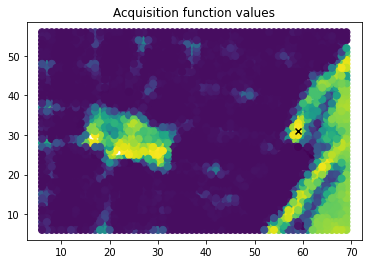

37/40
Epoch 1/200 ... Training loss: 0.8289
Epoch 10/200 ... Training loss: 0.7897
Epoch 20/200 ... Training loss: 0.745
Epoch 30/200 ... Training loss: 0.7009
Epoch 40/200 ... Training loss: 0.6566
Epoch 50/200 ... Training loss: 0.6127
Epoch 60/200 ... Training loss: 0.5687
Epoch 70/200 ... Training loss: 0.5262
Epoch 80/200 ... Training loss: 0.4817
Epoch 90/200 ... Training loss: 0.4374
Epoch 100/200 ... Training loss: 0.392
Epoch 110/200 ... Training loss: 0.346
Epoch 120/200 ... Training loss: 0.2995
Epoch 130/200 ... Training loss: 0.2528
Epoch 140/200 ... Training loss: 0.2058
Epoch 150/200 ... Training loss: 0.1586
Epoch 160/200 ... Training loss: 0.1113
Epoch 170/200 ... Training loss: 0.0641
Epoch 180/200 ... Training loss: 0.0169
Epoch 190/200 ... Training loss: -0.0304
Epoch 200/200 ... Training loss: -0.0775


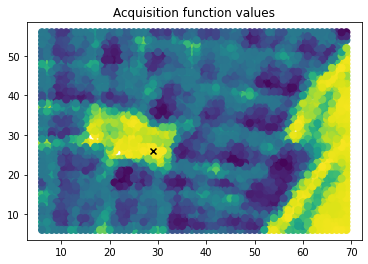

38/40
Epoch 1/200 ... Training loss: 0.8273
Epoch 10/200 ... Training loss: 0.7928
Epoch 20/200 ... Training loss: 0.7446
Epoch 30/200 ... Training loss: 0.6995
Epoch 40/200 ... Training loss: 0.6551
Epoch 50/200 ... Training loss: 0.6111
Epoch 60/200 ... Training loss: 0.5675
Epoch 70/200 ... Training loss: 0.5267
Epoch 80/200 ... Training loss: 0.4817
Epoch 90/200 ... Training loss: 0.4364
Epoch 100/200 ... Training loss: 0.3912
Epoch 110/200 ... Training loss: 0.3454
Epoch 120/200 ... Training loss: 0.2991
Epoch 130/200 ... Training loss: 0.2526
Epoch 140/200 ... Training loss: 0.2053
Epoch 150/200 ... Training loss: 0.1579
Epoch 160/200 ... Training loss: 0.1104
Epoch 170/200 ... Training loss: 0.0628
Epoch 180/200 ... Training loss: 0.0154
Epoch 190/200 ... Training loss: -0.0321
Epoch 200/200 ... Training loss: -0.0794


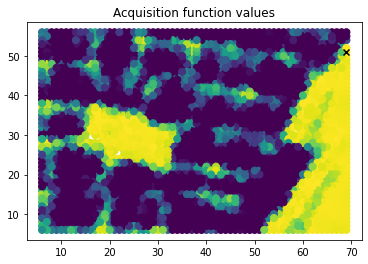

39/40
Epoch 1/200 ... Training loss: 0.8256
Epoch 10/200 ... Training loss: 0.7866
Epoch 20/200 ... Training loss: 0.7428
Epoch 30/200 ... Training loss: 0.6987
Epoch 40/200 ... Training loss: 0.6547
Epoch 50/200 ... Training loss: 0.6105
Epoch 60/200 ... Training loss: 0.5668
Epoch 70/200 ... Training loss: 0.5232
Epoch 80/200 ... Training loss: 0.4789
Epoch 90/200 ... Training loss: 0.4394
Epoch 100/200 ... Training loss: 0.3891
Epoch 110/200 ... Training loss: 0.3433
Epoch 120/200 ... Training loss: 0.297
Epoch 130/200 ... Training loss: 0.2507
Epoch 140/200 ... Training loss: 0.2038
Epoch 150/200 ... Training loss: 0.1565
Epoch 160/200 ... Training loss: 0.109
Epoch 170/200 ... Training loss: 0.0615
Epoch 180/200 ... Training loss: 0.0139
Epoch 190/200 ... Training loss: -0.0335
Epoch 200/200 ... Training loss: -0.081


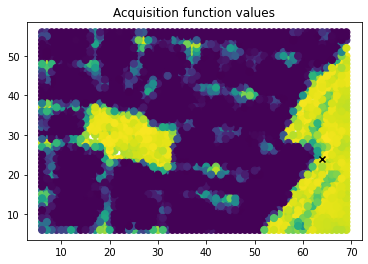

40/40
Epoch 1/200 ... Training loss: 0.8241
Epoch 10/200 ... Training loss: 0.7867
Epoch 20/200 ... Training loss: 0.7404
Epoch 30/200 ... Training loss: 0.6967
Epoch 40/200 ... Training loss: 0.6529
Epoch 50/200 ... Training loss: 0.6089
Epoch 60/200 ... Training loss: 0.5651
Epoch 70/200 ... Training loss: 0.5266
Epoch 80/200 ... Training loss: 0.483
Epoch 90/200 ... Training loss: 0.4368
Epoch 100/200 ... Training loss: 0.3902
Epoch 110/200 ... Training loss: 0.3445
Epoch 120/200 ... Training loss: 0.2985
Epoch 130/200 ... Training loss: 0.2517
Epoch 140/200 ... Training loss: 0.2047
Epoch 150/200 ... Training loss: 0.1574
Epoch 160/200 ... Training loss: 0.1099
Epoch 170/200 ... Training loss: 0.0622
Epoch 180/200 ... Training loss: 0.0145
Epoch 190/200 ... Training loss: -0.0334
Epoch 200/200 ... Training loss: -0.0813


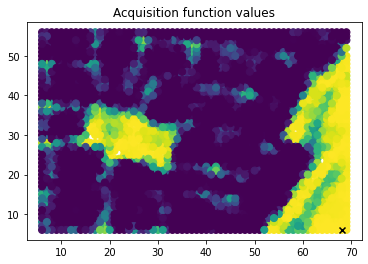

In [38]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=50, c=obj)
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp2 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp2.fit(X_train, y_train, training_cycles=200)
    # Thompson sampling
    obj, next_point_idx = dklgp2.thompson(X_test)
    # Select next point to "measure"
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point, 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

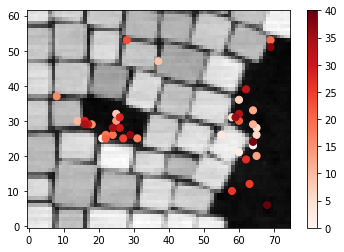

In [39]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

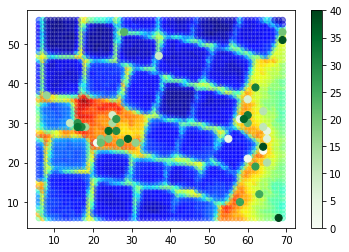

In [40]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized. We note that in addition to the built-in Thompson sampler used here, one can utilize different types of [acquisition functions](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf) for selecting the next measurement points.